# Country model error analysis

Analysis of the `uniform_summary.csv` dataset based on _dendrogram and heat map_ visulization, then comparison of different clustering methods, then network partitioning, based on the following tutorials:

  * <https://python-graph-gallery.com/404-dendrogram-with-heat-map/>
  * <https://seaborn.pydata.org/generated/seaborn.clustermap.html>
  * <https://www.geeksforgeeks.org/hierarchically-clustered-heatmap-in-python-with-seaborn-clustermap/>
  * <https://thelinuxcode.com/seaborn-cluster-map/>
  * <https://scikit-learn.org/stable/modules/clustering.html>
  * <https://networkx.org/documentation/stable/tutorial.html>

The goal is to be able to partition the countries into `N` groups to select the proper model while reducing errors in `address => country` predictions.

## set up environment

Load the library dependencies

In [1]:
from collections import defaultdict
import math
import typing
import warnings

from icecream import ic
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pycountry
import pyvis
import seaborn as sns
import scipy
import watermark

Optional: filter the less useful warnings

In [2]:
#warnings.filterwarnings("ignore")

Show a watermark of the OS, hardware, language environment, and dependent library versions.

In [3]:
%load_ext watermark
%watermark
%watermark --iversions

Last updated: 2025-01-24T16:04:28.986210-08:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.31.0

Compiler    : Clang 13.0.0 (clang-1300.0.29.30)
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

numpy     : 2.2.1
matplotlib: 3.10.0
seaborn   : 0.13.2
watermark : 2.5.0
scipy     : 1.15.1
pyvis     : 0.3.2
networkx  : 3.4.2
pycountry : 24.6.1
pandas    : 2.2.3



## data prep

Load the `uniform` dataset, which is a subset of up to 1k addresses from each country, where that many exist.

In [4]:
file_path: str = "data/uniform_summary.csv"
df: pd.DataFrame = pd.read_csv(file_path)
df = df.set_index("country")
df.head()

,expected model,% correct,count correct,count wrong,['ad'],['ae'],['af'],['ag'],['ai'],['al'],...,['vn'],['vu'],['wf'],['ws'],['xk'],['ye'],['yt'],['za'],['zm'],['zw']
country,,,,,,,,,,,,,,,,,,,,,
tw,['tw'],0.263,263,737,0.0,0.000,0.0,0.0,0.000,0.0,...,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.000
jp,['jp'],0.880,880,120,0.0,0.000,0.0,0.0,0.000,0.0,...,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.000
kr,['kr'],0.989,989,11,0.0,0.000,0.0,0.0,0.000,0.0,...,0.001,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.000
cn,['cn'],0.934,934,66,0.0,0.000,0.0,0.0,0.000,0.0,...,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.000
us,['us'],0.807,807,193,0.0,0.001,0.0,0.0,0.002,0.0,...,0.000,0.0,0.0,0.001,0.0,0.0,0.0,0.012,0.001,0.002


Drop all columns except for independent and dependent variables

In [5]:
df = df.drop(df.columns[[0, 1, 2, 3]], axis = 1)
df.head()

,['ad'],['ae'],['af'],['ag'],['ai'],['al'],['am'],['ao'],['ar'],['as'],...,['vn'],['vu'],['wf'],['ws'],['xk'],['ye'],['yt'],['za'],['zm'],['zw']
country,,,,,,,,,,,,,,,,,,,,,
tw,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,...,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.000
jp,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,...,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.000
kr,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,...,0.001,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.000
cn,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,...,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.000
us,0.0,0.001,0.0,0.0,0.002,0.0,0.0,0.0,0.001,0.0,...,0.000,0.0,0.0,0.001,0.0,0.0,0.0,0.012,0.001,0.002


Clean the column names

In [6]:
df.columns = [
    (name.strip()[2:])[:2]
    for name in df.columns.values.tolist()
]

df.head()

,ad,ae,af,ag,ai,al,am,ao,ar,as,...,vn,vu,wf,ws,xk,ye,yt,za,zm,zw
country,,,,,,,,,,,,,,,,,,,,,
tw,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,...,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.000
jp,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,...,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.000
kr,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,...,0.001,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.000
cn,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,...,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.000
us,0.0,0.001,0.0,0.0,0.002,0.0,0.0,0.0,0.001,0.0,...,0.000,0.0,0.0,0.001,0.0,0.0,0.0,0.012,0.001,0.002


Create a scaled, normalized view of the data as a `numpy` array, where each variable has mean of `0` and standard dev of `1`, to use as input formatted for the `scikit-learn` clustering algorithms.

In [7]:
from sklearn.preprocessing import StandardScaler

scaled_data: np.ndarray = StandardScaler().fit_transform(df)

Create a labeled view by expanding the full country names, based on ISO 3166

In [8]:
def map_cc_name (
    country: str,
    ) -> str:
    """
    Map from a country code to its expanded name based on ISO 3166
    """
    try:
        if pycountry.countries.lookup(country):
            name = pycountry.countries.get(alpha_2=country).name
            return f"{ country } - { name }"
    except:
        return f"{ country } ???"
   

df_labeled = df.copy(deep = True)

df_labeled.columns = [
    map_cc_name(name)
    for name in df.columns.values.tolist()
]

df_labeled.head()

,ad - Andorra,ae - United Arab Emirates,af - Afghanistan,ag - Antigua and Barbuda,ai - Anguilla,al - Albania,am - Armenia,ao - Angola,ar - Argentina,as - American Samoa,...,vn - Viet Nam,vu - Vanuatu,wf - Wallis and Futuna,ws - Samoa,xk ???,ye - Yemen,yt - Mayotte,za - South Africa,zm - Zambia,zw - Zimbabwe
country,,,,,,,,,,,,,,,,,,,,,
tw,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,...,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.000
jp,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,...,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.000
kr,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,...,0.001,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.000
cn,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,...,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.000
us,0.0,0.001,0.0,0.0,0.002,0.0,0.0,0.0,0.001,0.0,...,0.000,0.0,0.0,0.001,0.0,0.0,0.0,0.012,0.001,0.002


## interactive visualization

/Users/paco/src/cc_cluster/venv/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/paco/src/cc_cluster/venv/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


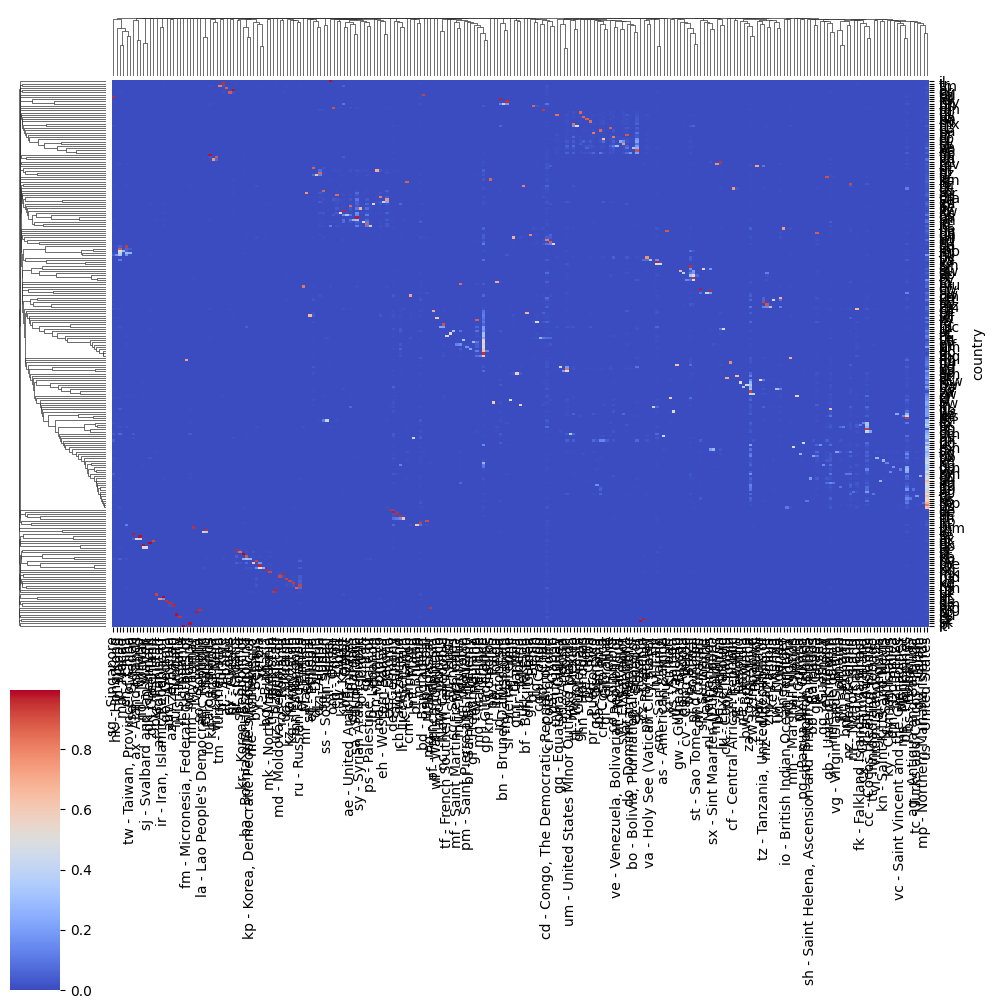

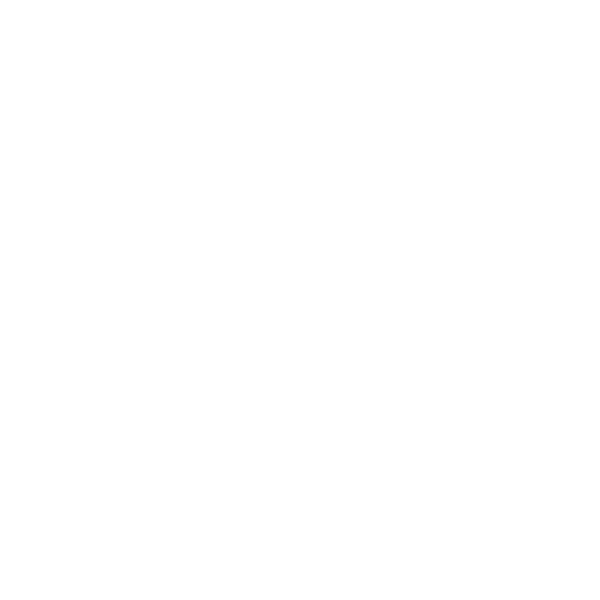

In [9]:
%matplotlib widget

plt.figure(figsize = (6, 6,))

sns_plot: sns.matrix.ClusterGrid = sns.clustermap(
    df_labeled,
    method = "average",
    metric = "correlation",
    #standard_scale = 1,
    #z_score = 1,
    xticklabels = True,
    yticklabels = True,
    cmap = "coolwarm", 
    dendrogram_ratio = (.1, .1),
)

sns_plot.cax.set_position((0.01, 0.01, 0.05, 0.3))
plt.tick_params(axis = "x", which = "both", rotation = 0)

plt.savefig("cluster.png")
plt.show()

## k-means clustering

In [10]:
from sklearn.cluster import KMeans

# instantiate the k-means class, specifying an optimal number of clusters
K: int = 10

kmeans = KMeans(
    init = "random",
    n_clusters = K,
    n_init = 10,
    random_state = 1,
)

# fit k-means algorithm to data and set cluster assignment in a dataframe

kmeans.fit(scaled_data)
predicted: list = kmeans.labels_

In [11]:
df_normalized = df.copy(deep = True)
df_normalized["cluster"] = predicted

clusters: dict = defaultdict(set)

for index, row in df_normalized.iterrows():
    clust_id: int = int(row["cluster"])
    clusters[clust_id].add(index)

In [12]:
for key, val in clusters.items():
    print(key, len(val))

    for country in val:
        print("", map_cc_name(country))

1 180
 bn - Brunei Darussalam
 ms - Montserrat
 by - Belarus
 bl - Saint Barthélemy
 vn - Viet Nam
 la - Lao People's Democratic Republic
 mk - North Macedonia
 nr - Nauru
 mf - Saint Martin (French part)
 sl - Sierra Leone
 gn - Guinea
 mv - Maldives
 ca - Canada
 af - Afghanistan
 cd - Congo, The Democratic Republic of the
 cf - Central African Republic
 nl - Netherlands
 sz - Eswatini
 mt - Malta
 is - Iceland
 cc - Cocos (Keeling) Islands
 qa - Qatar
 sm - San Marino
 ls - Lesotho
 ml - Mali
 va - Holy See (Vatican City State)
 li - Liechtenstein
 tz - Tanzania, United Republic of
 mz - Mozambique
 no - Norway
 bf - Burkina Faso
 cv - Cabo Verde
 jo - Jordan
 kg - Kyrgyzstan
 au - Australia
 gb - United Kingdom
 rs - Serbia
 hu - Hungary
 cx - Christmas Island
 br - Brazil
 td - Chad
 in - India
 tl - Timor-Leste
 il - Israel
 gl - Greenland
 tj - Tajikistan
 cn - China
 bt - Bhutan
 ad - Andorra
 az - Azerbaijan
 ax - Åland Islands
 dj - Djibouti
 ee - Estonia
 pk - Pakistan
 mn -

**Analysis:**

K-means works reasonably well for distinguishing among the smaller groupings, although it's not particularly effective working from the full `uniform` dataset down into groups.

## hierarchical clustering

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# Perform agglomerative clustering
agg_clustering = AgglomerativeClustering(n_clusters = 4)
predicted: list = agg_clustering.fit_predict(scaled_data)

predicted

array([2, 2, 0, 2, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
       3, 3, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3,
       0, 0, 1, 3, 1, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0])

In [14]:
df_normalized = df.copy(deep = True)
df_normalized["cluster"] = predicted

clusters: dict = defaultdict(set)

for index, row in df_normalized.iterrows():
    clust_id: int = int(row["cluster"])
    clusters[clust_id].add(index)

In [15]:
for key, val in clusters.items():
    print(key, len(val))

    for country in val:
        print("", map_cc_name(country))

2 5
 mo - Macao
 jp - Japan
 cn - China
 tw - Taiwan, Province of China
 hk - Hong Kong
0 183
 bn - Brunei Darussalam
 by - Belarus
 vn - Viet Nam
 la - Lao People's Democratic Republic
 na - Namibia
 mk - North Macedonia
 gn - Guinea
 mv - Maldives
 sx - Sint Maarten (Dutch part)
 af - Afghanistan
 cd - Congo, The Democratic Republic of the
 cr - Costa Rica
 nl - Netherlands
 cf - Central African Republic
 sz - Eswatini
 mt - Malta
 is - Iceland
 qa - Qatar
 sm - San Marino
 ls - Lesotho
 ml - Mali
 va - Holy See (Vatican City State)
 li - Liechtenstein
 tz - Tanzania, United Republic of
 ly - Libya
 mz - Mozambique
 no - Norway
 ve - Venezuela, Bolivarian Republic of
 bf - Burkina Faso
 cv - Cabo Verde
 jo - Jordan
 kg - Kyrgyzstan
 sv - El Salvador
 rs - Serbia
 hu - Hungary
 br - Brazil
 td - Chad
 in - India
 ec - Ecuador
 tl - Timor-Leste
 il - Israel
 py - Paraguay
 tj - Tajikistan
 gl - Greenland
 bt - Bhutan
 ad - Andorra
 az - Azerbaijan
 ax - Åland Islands
 dj - Djibouti
 ee

**Analysis:**

Hierarchical clustering could likely work well if we approached this "recursively", that is by redacting the smaller groupings from the top level, then repeating the analysis. For example in the report above, the `{ Taiwan, Macao, China, Japan, Hong Kong }` cluster could be redacted at the first iteration.

## network partitioning

Construct a graph of the country classifier error, using `NetworkX`

In [16]:
def build_graph (
    df_graph: pd.DataFrame,
    min_error: float,
    node_labels: list,
    exclude: set,
    ) -> nx.DiGraph:
    """
    Build a `NetworkX` directed graph from the dataframe, 
    excluding nodes from identifed cliques.
    """
    graph: nx.DiGraph = nx.DiGraph()

    for name in node_labels:
        src_id: int = node_labels.index(name)

        if src_id not in exclude:
            graph.add_node(
                src_id,
                name = name,
            )

        for index, row in df_graph.iterrows():   
            for dst_id, val in enumerate(list(row)):
                if dst_id not in exclude:
                    src_id: int = node_labels.index(index)

                    if src_id not in exclude and src_id != dst_id and val >= min_error:
                        graph.add_edge(src_id, dst_id)
                        graph[src_id][dst_id]["weight"] = val

    return graph

Partition based on the _weakly connected components_ in the graph, then report all but the largest component.

In [17]:
def extract_cliques (
    graph: nx.DiGraph,
    node_labels: list,
    exclude: set,
    groups: list,
    full: bool,
    ) -> None:
    """
    Iterate through the connected components, extracting cliques
    """
    max_len: int = max([len(clique) for clique in nx.weakly_connected_components(graph)])

    for clique in nx.weakly_connected_components(graph):
        len_clique: int = len(clique)
    
        if full or len_clique < max_len:            
            group: set = set([
                map_cc_name(node_labels[i])
                for i in clique
            ])

            if len_clique > 1:
                print(len_clique, group)

            groups.append(clique)
            
            if not full:
                for i in clique:
                    exclude.add(i)

NB: adjust the `MIN_ERROR` threshold to partition the graph differently.
Using _hierarchical clustering_ this would have been a recursive problem; here we're unwinding the recursion in a loop.

In [18]:
df_graph = df.copy(deep = True)

NODE_LABELS: list = list(df_graph.columns)
EXCLUDE: set = set()
GROUPS: list = []

In [19]:
# interesting thresholds:
#   >= 0.2 partitions the graph into language family and regions

for min_error in [ 0.01, 0.05, 0.1, 0.25, 0.3, 0.4 ]:
    graph: nx.DiGraph = build_graph(df_graph, min_error, NODE_LABELS, EXCLUDE)
    extract_cliques(graph, NODE_LABELS, EXCLUDE, GROUPS, full = False)
    ic(min_error, len(EXCLUDE), len(GROUPS))

ic| min_error: 0.01, len(EXCLUDE): 10, len(GROUPS): 9


2 {'az - Azerbaijan', 'am - Armenia'}


ic| min_error: 0.05, len(EXCLUDE): 68, len(GROUPS): 51


9 {'me - Montenegro', 'by - Belarus', 'rs - Serbia', 'xk ???', "kp - Korea, Democratic People's Republic of", 'mn - Mongolia', 'kr - Korea, Republic of', 'ba - Bosnia and Herzegovina', 'ru - Russian Federation'}
4 {'dj - Djibouti', 'dz - Algeria', 'tn - Tunisia', 'et - Ethiopia'}
2 {"la - Lao People's Democratic Republic", 'th - Thailand'}
3 {'se - Sweden', 'fi - Finland', 'ax - Åland Islands'}
2 {'af - Afghanistan', 'ir - Iran, Islamic Republic of'}
2 {'no - Norway', 'sj - Svalbard and Jan Mayen'}


ic| min_error: 0.1, len(EXCLUDE): 102, len(GROUPS): 83


2 {'tl - Timor-Leste', 'mx - Mexico'}
2 {'eh - Western Sahara', 'ye - Yemen'}


ic| min_error: 0.25, len(EXCLUDE): 195, len(GROUPS): 160


2 {'ad - Andorra', 'es - Spain'}
5 {'cn - China', 'tw - Taiwan, Province of China', 'hk - Hong Kong', 'mo - Macao', 'jp - Japan'}
6 {'rw - Rwanda', 'bw - Botswana', 'zw - Zimbabwe', 'na - Namibia', 'ls - Lesotho', 'za - South Africa'}
2 {'ec - Ecuador', 'bo - Bolivia, Plurinational State of'}
2 {'sa - Saudi Arabia', 'bh - Bahrain'}
2 {'it - Italy', 'sm - San Marino'}
4 {'st - Sao Tome and Principe', 'pt - Portugal', 'cv - Cabo Verde', 'br - Brazil'}


ic| min_error: 0.3, len(EXCLUDE): 212, len(GROUPS): 167


2 {'ph - Philippines', 'ms - Montserrat'}
10 {'bl - Saint Barthélemy', 'gf - French Guiana', 'ht - Haiti', 'yt - Mayotte', 'fr - France', 'mq - Martinique', 'gp - Guadeloupe', 'pm - Saint Pierre and Miquelon', 'mf - Saint Martin (French part)', 'tf - French Southern Territories'}


ic| min_error: 0.4, len(EXCLUDE): 227, len(GROUPS): 181


2 {'cc - Cocos (Keeling) Islands', 'au - Australia'}


Render an interactive visualization using `PyVis` of what remains in the largest component

In [20]:
def render_graph (
    graph: nx.DiGraph,
    ) -> pyvis.network.Network:
    """
    Generate a `PyVis` network visualization from the DiGraph
    """
    net: pyvis.network.Network = pyvis.network.Network(
        notebook = True,
        cdn_resources = "in_line",
        height = "700px", 
        width = "100%",
    )

    # calculate the _betweenness centrality_ measures for each country
    cent: dict = nx.betweenness_centrality(graph, weight = "weight")

    for src_id, dat in graph.nodes(data = True):
        graph.nodes[src_id]["value"] = cent[src_id]

    # load the network and adjust attributes for visualization
    net.from_nx(graph)

    for node in net.nodes:
        node["label"] = map_cc_name(node["name"])

    for edge in net.edges:
        #edge["value"] = edge["width"]
        pass

    return net

In [21]:
net: pyvis.network.Network = render_graph(graph)

net.force_atlas_2based()
net.show_buttons(filter_ = ["physics"])

#net.toggle_physics(False)
net.show("networkx-pyvis.html")

networkx-pyvis.html


Finish the groups and report the results

In [22]:
extract_cliques(graph, NODE_LABELS, EXCLUDE, GROUPS, full = True)

18 {'sh - Saint Helena, Ascension and Tristan da Cunha', 'nf - Norfolk Island', 'im - Isle of Man', 'ky - Cayman Islands', 'bs - Bahamas', 'gu - Guam', 'us - United States', 'sb - Solomon Islands', 'mp - Northern Mariana Islands', 'mh - Marshall Islands', 'ai - Anguilla', 'io - British Indian Ocean Territory', 'gd - Grenada', 'tc - Turks and Caicos Islands', 'tt - Trinidad and Tobago', 'jm - Jamaica', 'lc - Saint Lucia', 'ag - Antigua and Barbuda'}
2 {'cc - Cocos (Keeling) Islands', 'au - Australia'}


In [23]:
for clique in GROUPS:
    if len(clique) > 1:
        group: set = set([
            map_cc_name(NODE_LABELS[i])
            for i in clique
        ])

        print(clique)
        print(group)

{14, 6}
{'az - Azerbaijan', 'am - Armenia'}
{32, 134, 141, 239, 15, 115, 116, 184, 185}
{'me - Montenegro', 'by - Belarus', 'rs - Serbia', 'xk ???', "kp - Korea, Democratic People's Republic of", 'mn - Mongolia', 'kr - Korea, Republic of', 'ba - Bosnia and Herzegovina', 'ru - Russian Federation'}
{65, 217, 58, 54}
{'dj - Djibouti', 'dz - Algeria', 'tn - Tunisia', 'et - Ethiopia'}
{120, 212}
{"la - Lao People's Democratic Republic", 'th - Thailand'}
{66, 13, 191}
{'se - Sweden', 'fi - Finland', 'ax - Åland Islands'}
{2, 102}
{'af - Afghanistan', 'ir - Iran, Islamic Republic of'}
{161, 195}
{'no - Norway', 'sj - Svalbard and Jan Mayen'}
{151, 215}
{'tl - Timor-Leste', 'mx - Mexico'}
{240, 62}
{'eh - Western Sahara', 'ye - Yemen'}
{0, 64}
{'ad - Andorra', 'es - Spain'}
{108, 44, 142, 90, 222}
{'cn - China', 'tw - Taiwan, Province of China', 'hk - Hong Kong', 'mo - Macao', 'jp - Japan'}
{186, 242, 244, 154, 126, 31}
{'rw - Rwanda', 'bw - Botswana', 'zw - Zimbabwe', 'na - Namibia', 'ls - Le

Finally, visualize a network with all the groups together

## incorporate other countries

Now start with a curated list of country groups, based on the connected components analysis plus domain knowledge.

In [24]:
CURATED: typing.Dict[ str, typing.Set[ int ] ] = {
    "latin":
    {151, 215, 0, 64, 59, 27, 104, 198, 48, 178, 203, 28, 146, 171, 71, 135, 76, 174, 144, 241, 210, 83, 24, 93, 33, 57, 84, 232, 132, 7, 159, 88, 38, 128, 46, 189, 201, 12, 72, 199, 169, 37, 45, 204, 176, 182, 180, 155, 82, 40, 42, 228, 86, 47, 153, 8, 168, 167, 91, 18, 105, 230},

    "anglo":
    {160, 11, 35, 193, 98, 227, 4, 3, 100, 137, 106, 74, 143, 208, 220, 157, 87, 118, 122, 188, 29, 112, 68, 175, 50, 231, 114, 170, 234, 233, 56, 77, 205, 147, 9, 226, 73, 179, 163, 125, 79, 67, 238, 41, 236, 237, 221, 34, 69, 36, 63, 165, 96, 148, 78, 164, 25, 16, 214, 218, 149, 113, 223, 70, 136, 202, 225},

    "scandinavia":
    {66, 13, 191, 161, 195, 55, 80, 103},

    "german":
    {53, 10, 123, 39, 60},
    
    "east_slavic":
    {32, 134, 141, 239, 15, 115, 116, 184, 185, 224, 194, 133, 183, 20, 127, 119, 110, 92, 213, 173, 229},

    "west_slavic":
    {52, 196, 138},

    "africa":
    {186, 242, 244, 154, 126, 31, 150, 207, 89, 243, 109, 197, 211, 81, 156, 43, 19, 158, 22, 139, 23},
    
    "arab":
    {240, 62, 187, 21, 65, 217, 58, 54, 130, 177, 181, 145, 206, 121, 131, 190, 101, 107, 1, 61, 166, 209, 117, 200},

    "east_asia":
    {108, 44, 142, 90, 222, 30, 140, 235, 152, 192, 111, 26, 212},

    "greek":
    {85, 5, 51},

    "turkic":
    {219, 216},

    "persian":
    {2, 102, 14, 6, 75},

    "indian":
    {99, 172, 162, 49, 124, 17, 95, 120},
}

Let's iterate on the following two steps, determining the best matches for each ungrouped country, and adding these to the `CURATED` groups manually.

In [25]:
curated_ids: set = set()

for region, group in CURATED.items():
    print(region)

    for cc_id in group:
        curated_ids.add(cc_id)
        cc_abbr: str = NODE_LABELS[cc_id]
        cc_name: str = map_cc_name(cc_abbr)
        print(f"   {cc_id:4d}  {cc_name}")

latin
      0  ad - Andorra
    128  lu - Luxembourg
    132  mc - Monaco
      7  ao - Angola
    135  mf - Saint Martin (French part)
      8  ar - Argentina
     12  aw - Aruba
    144  mq - Martinique
    146  ms - Montserrat
     18  be - Belgium
    151  mx - Mexico
     24  bl - Saint Barthélemy
    153  mz - Mozambique
    155  nc - New Caledonia
     27  bo - Bolivia, Plurinational State of
     28  br - Brazil
    159  ni - Nicaragua
     33  bz - Belize
     37  cf - Central African Republic
     38  cg - Congo
    167  pa - Panama
     40  ci - Côte d'Ivoire
    169  pf - French Polynesia
     42  cl - Chile
    171  ph - Philippines
    168  pe - Peru
     45  co - Colombia
    174  pm - Saint Pierre and Miquelon
     46  cr - Costa Rica
     48  cv - Cabo Verde
    176  pr - Puerto Rico
    178  pt - Portugal
     47  cu - Cuba
    180  py - Paraguay
    182  re - Réunion
     57  do - Dominican Republic
     59  ec - Ecuador
    189  sc - Seychelles
     64  es - Spain
 

In [26]:
def pairwise_error (
    src_id: int,
    dst_id: int,
    ) -> float:
    """
    Access the error value from the dataframe
    """
    return df_graph.loc[NODE_LABELS[src_id]].iloc[dst_id]

In [27]:
known_ids: set = set(range(len(NODE_LABELS)))
missed_ids: set = known_ids - curated_ids
nearest: list = []

for cc_id in missed_ids:
    cc_dist: list = []

    for region, group in CURATED.items():
        err_vect: list = [
            pairwise_error(cc_id, dst_id)
            for dst_id in group
        ]
        
        rms: float = math.sqrt(sum([
            math.pow(x, 2.0)
            for x in err_vect
        ]) / len(err_vect) )

        cc_dist.append([ rms, region ])

    cc_dist.sort(reverse = True)
    nearest.append([ cc_dist[0][0], cc_id, cc_dist[0][1] ])

nearest.sort(reverse = True)

At this point we have "remnants" which are anomalies or countries with relatively low error rates overall, which are effectively within a _margin of error_. These may be language isolates are a national language, such as Hungary.

For these, we probably should add them to the "anglo" group as a catch-all?

In [28]:
for dist, cc_id, region in nearest:
    cc_abbr: str = NODE_LABELS[cc_id]
    cc_name: str = map_cc_name(cc_abbr)
    print(f"{dist:.4f}  {cc_id:4d}  {cc_name}  {region}")

0.0021   129  lv - Latvia  anglo
0.0009    94  hu - Hungary  anglo
0.0008    97  il - Israel  anglo


## visualize results

In [29]:
graph: nx.DiGraph = nx.DiGraph()

for region, clique in CURATED.items():
    for src_id in clique:
        graph.add_node(
            src_id,
            name = NODE_LABELS[src_id],
        )

        for dst_id in clique:
            if src_id != dst_id:
                graph.add_edge(src_id, dst_id)
                graph[src_id][dst_id]["weight"] = pairwise_error(src_id, dst_id)

In [30]:
net: pyvis.network.Network = render_graph(graph)

net.force_atlas_2based()
net.show_buttons(filter_ = ["physics"])

#net.toggle_physics(False)
net.show("networkx-pyvis.html")

networkx-pyvis.html


Note: to see the final graph, load the HTML file `network-pyvis.html` in your browser.

In [32]:
len(graph.nodes)

242